# **Customer Lifetime Value (CLV) & Churn Prediction**

## ***Exploratory Data Analysis***
This EDA will include some important analysis to better understand the business progress and customer behaviour such as:
1. **Core Business Questions**
    * Which customer segments bring most revenue?
    * Are repeat customers more profitable?
    * Which product categories drive CLV?
    * Which behaviors signal churn?
2. Key Visualizations
    * Revenue trend over time
    * Cohort Analysis (Customer Retention by Month)
    * RFM Distribution
    * Seasonality & Spending patterns
3. Feature Insights for ML
    * Who to retain
    * Discount or loyalty program targets
    * Top 10 risk customers & revenue at risk

In [58]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
# Importing Dataset
# Importing the cleaned dataset from the previous step
df = pd.read_csv('cleaned_transactions.csv', parse_dates=['invoice_date'])
df.head()

,invoice,stockcode,description,quantity,price,customer_id,country,invoice_date,total_price
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,6.95,13085.0,United Kingdom,2009-12-01 07:45:00,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,6.75,13085.0,United Kingdom,2009-12-01 07:45:00,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,6.75,13085.0,United Kingdom,2009-12-01 07:45:00,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2.10,13085.0,United Kingdom,2009-12-01 07:45:00,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,1.25,13085.0,United Kingdom,2009-12-01 07:45:00,30.0


### **2. Data Overview**

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779495 entries, 0 to 779494
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice       779495 non-null  int64         
 1   stockcode     779495 non-null  object        
 2   description   779495 non-null  object        
 3   quantity      779495 non-null  int64         
 4   price         779495 non-null  float64       
 5   customer_id   779495 non-null  float64       
 6   country       779495 non-null  object        
 7   invoice_date  779495 non-null  datetime64[ns]
 8   total_price   779495 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 53.5+ MB


In [61]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
invoice,779495.0,537427.005391,489434.0,514483.0,536754.0,562002.0,581587.0,26901.96111
quantity,779495.0,13.507085,1.0,2.0,6.0,12.0,80995.0,146.540284
price,779495.0,3.218199,0.0,1.25,1.95,3.75,10953.5,29.674823
customer_id,779495.0,15320.262918,12346.0,13971.0,15246.0,16794.0,18287.0,1695.722988
invoice_date,779495,2011-01-03 01:46:36.061116416,2009-12-01 07:45:00,2010-07-02 14:39:00,2010-12-02 14:09:00,2011-08-01 13:48:00,2011-12-09 12:50:00,NaN
total_price,779495.0,22.289821,0.0,4.95,12.48,19.8,168469.6,227.416962


In [62]:
df.nunique()

invoice         36975
stockcode        4631
description      5283
quantity          438
price             666
customer_id      5881
country            41
invoice_date    34591
total_price      3735
dtype: int64

* The dataset contains 779495 rows, 9 columns and 5881 customers.
* Average Revenue per transaction is around 22.28.
* No column have any critical missing values after cleaning.

## **2. Revenue Analysis**
Analysing the Revenue pattern in the dataset

* Top Countries by Revenue

In [63]:
df.groupby('country')['total_price'].sum().sort_values(ascending=False).head(10)


country
United Kingdom    1.438923e+07
EIRE              6.165705e+05
Netherlands       5.540381e+05
Germany           4.250197e+05
France            3.487690e+05
Australia         1.692835e+05
Spain             1.083325e+05
Switzerland       1.000619e+05
Sweden            9.151582e+04
Denmark           6.858069e+04
Name: total_price, dtype: float64

* United Kingdom has contributed the most revenue.

* Monthly Revenue Trend

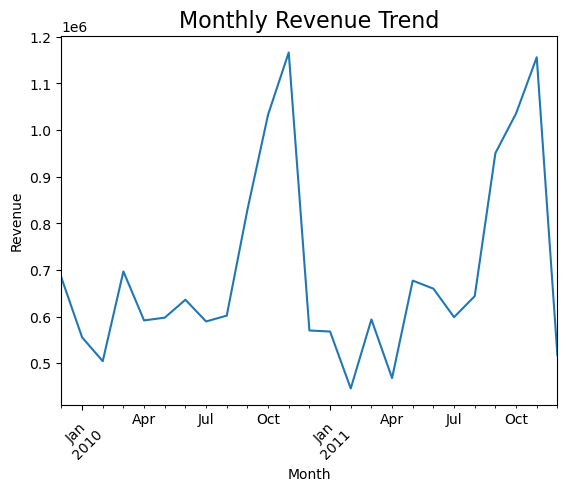

In [64]:
# Grouping by month to see revenue trends
df['month'] = df['invoice_date'].dt.to_period('M')
monthly_revenue = df.groupby('month')['total_price'].sum()

# Plotting the monthly revenue trend
monthly_revenue.plot(kind='line')
plt.title("Monthly Revenue Trend", fontsize=16)
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.show()


**Observations:**

* Revenue displays a strong seasonal trend, with the highest peaks occurring in the last quarter of each year, possiblly because of holidays season and end of year offers.
* The beginning of each year shows the lowest revenue levels, indicating a consistent post-holiday slowdown.
* Mid-year performance is moderate and fluctuates, suggesting variability in non-peak demand periods.
* Overall, revenue is growing but remains highly volatile, reflecting dependence on seasonal sales cycles.

### **3. Customer Behavior Analysis**
Extracting pattern from data to understand the customer behaviour. 

* Customer Purchase Frequency

Text(0.5, 1.0, 'Customer Purchase Frequency Distribution')

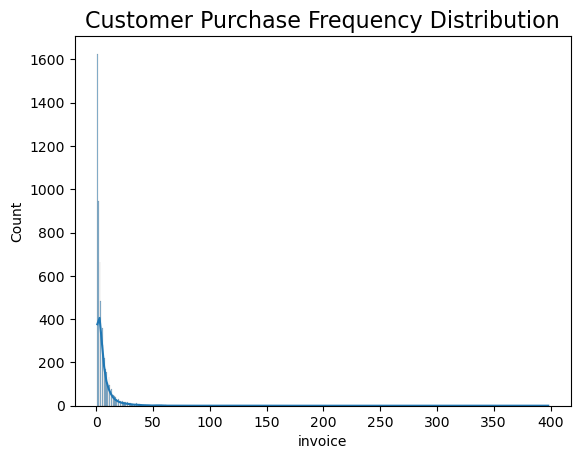

In [66]:
freq = df.groupby('customer_id')['invoice'].nunique()
sns.histplot(freq, kde=True)
plt.title("Customer Purchase Frequency Distribution", fontsize=16)


* Revenue per Customer

Text(0.5, 1.0, 'Revenue per Customer (Monetary Value)')

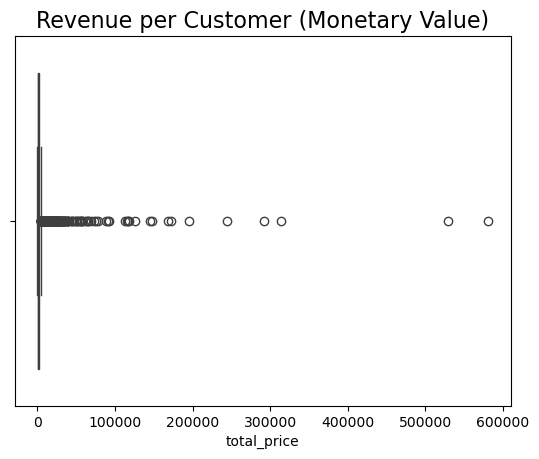

In [67]:
monetary = df.groupby('customer_id')['total_price'].sum()
sns.boxplot(x=monetary)
plt.title("Revenue per Customer (Monetary Value)", fontsize=16)


* Recency

Text(0.5, 1.0, 'Recency Distribution')

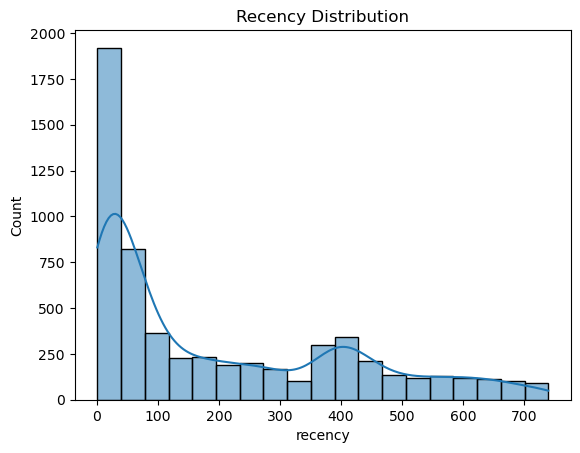

In [68]:
# Assigning the last invoice date as reference date for recency calculation
reference_date = df['invoice_date'].max() + pd.Timedelta(days=1)
# Calculating recency for each customer
df['recency'] = (reference_date - df['invoice_date']).dt.days
recency_df = df.groupby('customer_id')['recency'].min()

# Plotting recency distribution
sns.histplot(recency_df, kde=True)
plt.title("Recency Distribution")


**Observations:**
* There are very few customers who had made more than 25 purchases.
* Most of the customers spend less than 200000.
* Most of the customers as recency less than 40.

#### **4. Cohort Analysis**
Grouping customers in cohorts based on their first and next purchase month and counting which cohort has the most customers.

Text(0.5, 1.0, 'Cohort Retention Heatmap')

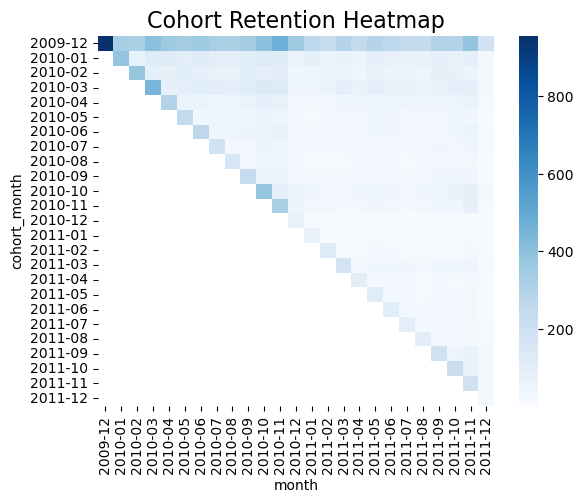

In [70]:
# Defining cohort month for each customer's first purchase
df['cohort_month'] = df.groupby('customer_id')['invoice_date'].transform('min').dt.to_period('M')

# Monthly unique customers by cohort
cohort_data = df.groupby(['cohort_month', 'month'])['customer_id'].nunique().reset_index()
cohort_pivot = cohort_data.pivot(index='cohort_month', columns='month', values='customer_id')

sns.heatmap(cohort_pivot, annot=False, cmap="Blues")
plt.title("Cohort Retention Heatmap", fontsize = 16)


**Observations:**
* Retention tends to drop over time for every cohort, new users gradually become inactive.
* The initial months show the highest activity, with numbers decreasing in later months.
* Some cohorts like end ending months of year show slightly better retention than others

#### **5. Detecting Potential Churn Signals**

1. Customers with No Purchase in Last 90 Days.

In [72]:
at_risk = recency_df[recency_df > 90]
print(f"Number of at-risk customers (no purchase in last 90 days): {at_risk.nunique()}")

Number of at-risk customers (no purchase in last 90 days): 586


2. Revenue at Risk

In [74]:
revenue_at_risk = monetary[at_risk.index].sum()
print("Estimated Revenue at Risk: ", revenue_at_risk)

Estimated Revenue at Risk:  3391383.658


Based on inactivity > 90 days, 586 customers show churn signals, risking approximately amount of 3391383.658 in revenue.

#### **Outlier Detection**

Text(0.5, 1.0, 'Revenue Outlier Check')

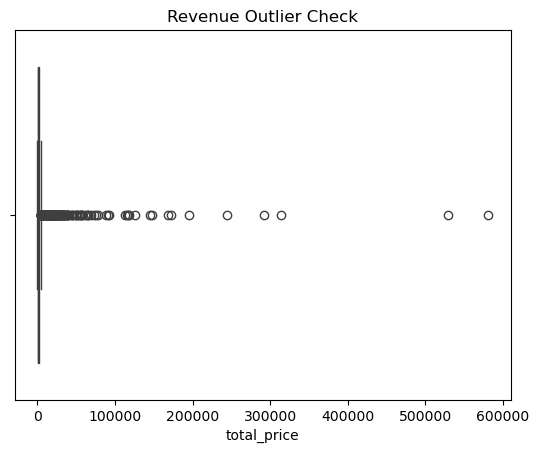

In [75]:
sns.boxplot(x=monetary)
plt.title("Revenue Outlier Check")

**Observations:**
* Most of the customers spends less than 100000.
* A very few customers spends between 100000-600000. These are our highest priority(VIP) customers and not outliers.

Instead of deleting them, they will be handled using **log-transformations and segmentation** in the Feature Engineering phase.

* ###  **Summary:**

Key Findings from EDA:
- Revenue is highest in end months due to holiday seasons.
- Customers with (high frequency + high monetary value) are the most loyal.
- Customers inactive for > 90 days show strong churn signals.
- Estimated revenue at risk: 3391383.658.
- Peak retention cohorts start dropping after 3 months.

These insights will guide feature engineering and modeling.